**recsys-cluster-loss**

Example of cluster analysis in the context of recommendation systems.
Users who receive recommendations will be grouped based on the individual fairness measure of those recommendations.
The objective is to analyze whether there is any type of injustice of non-obvious user groups, that is, groups that cannot be configured based on some explicit user characteristic (variable) (for example: gender, age, etc.) .

Two methods of grouping will be applied:
1. Hierarchical clustering (tree clustering - dendrogram)
2. Non-hierarchical grouping by breakdown (grouping by k-Means)

In this file we are analyzing the possible groupings considering the following variable(s):
- NR: number of ratings of users

Recommendation system: generating the recommendation matrix and calculating individual fairness

In [1]:
# cloning repository with database
!rm -rf recsys-cluster-loss
!git clone https://github.com/ravarmes/recsys-cluster-loss.git

Cloning into 'recsys-cluster-loss'...


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [3]:
import sys
sys.path.append('recsys-cluster-loss/src')
from RecSys import RecSys
from UserFairness import IndividualLossVariance
from UserFairness import GroupLossVariance

In [4]:
# reading data from 3883 movies and 6040 users 
Data_path = 'recsys-cluster-loss/data/MovieLens-1M'
n_users=  300
n_items= 1000
top_users = True # True: to use users with more ratings; False: otherwise
top_items = False # True: to use movies with more ratings; False: otherwise

In [5]:
# recommendation algorithm
algorithm = 'RecSysALS'

In [6]:
# parameters for calculating fairness measures
l = 5
theta = 3
k = 3

In [7]:
recsys = RecSys(n_users, n_items, top_users, top_items, l, theta, k)

In [8]:
X, users_info, items_info = recsys.read_movielens_1M(n_users, n_items, top_users, top_items, data_dir = Data_path) # returns matrix of ratings with n_users rows and n_moveis columns
omega = ~X.isnull() # matrix X with True in cells with evaluations and False in cells not rated

In [9]:
users_info

,Gender,Age,Occupation,Zip-code,NR
1,2,1,10,48067,53
2,1,56,16,70072,129
3,1,25,15,55117,51
4,1,45,7,02460,21
5,1,25,20,55455,198
...,...,...,...,...,...
6036,2,25,15,32603,888
6037,2,45,1,76006,202
6038,2,56,1,14706,20
6039,2,45,0,01060,123


In [10]:
X_est = recsys.compute_X_est(X, algorithm, Data_path) # RecSysALS or RecSysKNN or RecSysNMF or RecSysExampleAntidoteData20Items

In [11]:
ilv = IndividualLossVariance(X, omega, 1)
losses = ilv.get_losses(X_est)

In [12]:
losses

UserID
4169    0.611130
1680    1.132248
4277    0.414079
1941    1.047745
1181    0.587892
          ...   
3320    1.072202
3462    0.875762
5011    0.664776
308     0.358923
1333    1.164655
Length: 300, dtype: float64

In [13]:
df = pd.DataFrame(columns=['Gender', 'Age', 'Occupation', 'Zip-code', 'Loss'])
df['Gender'] = users_info['Gender']
df['Age'] = users_info['Age']
df['Occupation'] = users_info['Occupation']
df['Zip-code'] = users_info['Zip-code']
df['NR'] = users_info['NR']
df['Loss'] = losses

df.dropna(subset=['Loss'], inplace=True) # eliminating rows with empty values in the 'Loss' column
df

,Gender,Age,Occupation,Zip-code,Loss,NR
48,1,25,4,92107,0.370556,598
53,1,25,0,96931,0.516604,684
123,1,35,9,67208,0.487140,608
148,1,50,17,57747,1.033793,624
149,1,25,1,29205,0.607217,592
...,...,...,...,...,...,...
5916,1,50,20,48230,0.563316,704
5954,1,45,11,70802,1.492428,1000
5996,2,25,0,87114,0.751011,591
6016,1,45,1,37209,0.591682,909


In [14]:
df.head()

,Gender,Age,Occupation,Zip-code,Loss,NR
48,1,25,4,92107,0.370556,598
53,1,25,0,96931,0.516604,684
123,1,35,9,67208,0.487140,608
148,1,50,17,57747,1.033793,624
149,1,25,1,29205,0.607217,592


In [15]:
# number of rows and columns:
df.shape

(300, 6)

In [16]:
# descriptive statistics:
df.describe()

,Gender,Age,Occupation,Loss,NR
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,1.230000,28.776667,7.070000,0.788955,794.273333
std,0.421536,10.259515,6.641194,0.307327,228.929131
min,1.000000,1.000000,0.000000,0.293217,557.000000
25%,1.000000,25.000000,1.000000,0.578627,630.750000
50%,1.000000,25.000000,4.000000,0.727145,732.000000
75%,1.000000,35.000000,14.000000,0.915155,870.750000
max,2.000000,56.000000,20.000000,2.401739,2314.000000


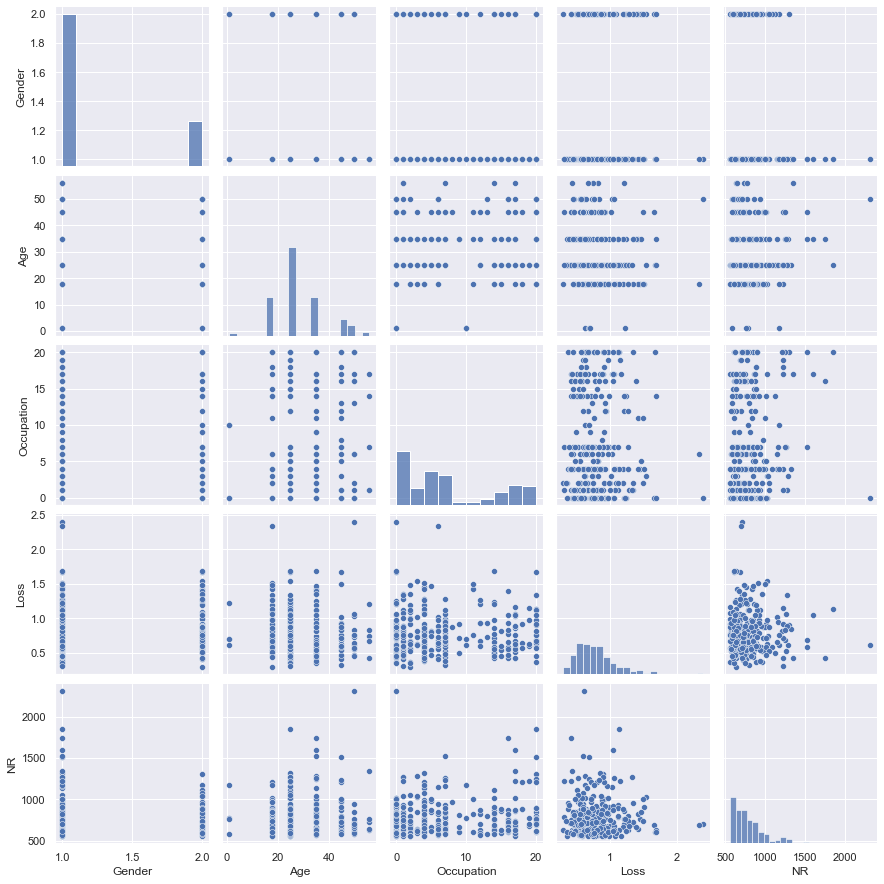

In [17]:
sns.pairplot(df)

<AxesSubplot:>

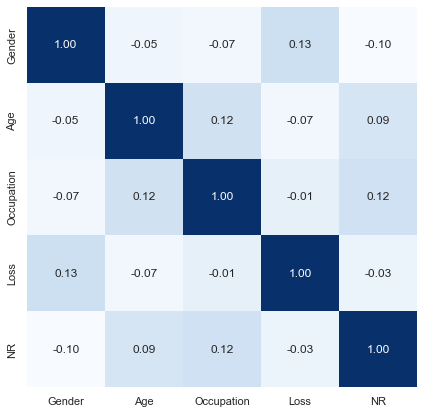

In [18]:
df = df.drop(['Zip-code'] , axis=1) # eliminating Zip-code (non-numeric) columns to analyze correlations

plt.figure(figsize=(7, 7))
corr = np.corrcoef(df.values, rowvar=False)
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', cbar=False, xticklabels=df.columns, yticklabels=df.columns)

Hierarchical clustering (tree clustering - dendrogram)

In [19]:
# Leaving only the NR column to perform cluster analysis
df = df.drop('Loss', 1)
df = df.drop('Age', 1) 
df = df.drop('Occupation', 1) 
df = df.drop('Gender', 1) 
#df = df.drop('NR', 1) 

In [20]:
df_scaled = df.copy()
df_scaled.iloc[:, :] = StandardScaler().fit_transform(df)

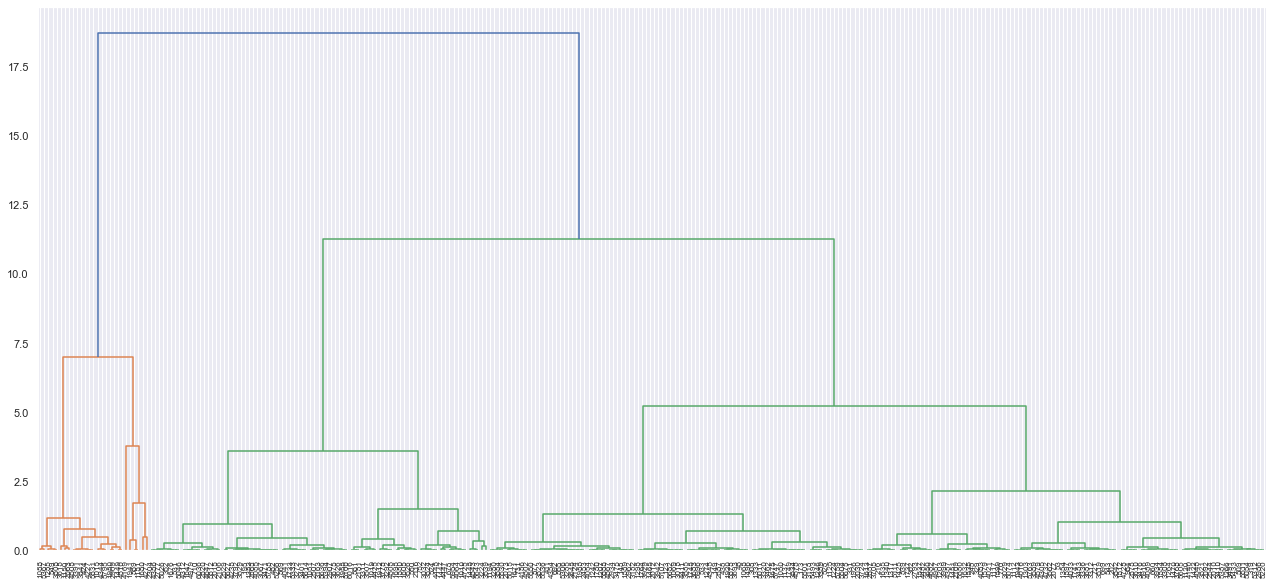

In [21]:
Z = hierarchy.linkage(df_scaled, 'ward') #complete or ward
plt.figure(figsize=(22, 10))
plt.grid(axis='y')
dn = hierarchy.dendrogram(Z, labels=list(df.index), leaf_font_size=8)

In [22]:
n_clusters = 3
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
df_scaled['cluster_agglomerative'] = cluster.fit_predict(df_scaled)

In [23]:
# descriptive statistics of groups
df_groups = df.copy()
df_groups["cluster_agglomerative"] = cluster.labels_
df_groups = df_groups.groupby("cluster_agglomerative")
df_groups.describe()

NR                                            \
                       count         mean         std     min      25%   
cluster_agglomerative                                                    
0                       27.0  1350.185185  262.789480  1144.0  1216.00   
1                      190.0   666.536842   70.740873   557.0   608.25   
2                       83.0   905.843373   74.201190   812.0   846.00   

                                                
                          50%      75%     max  
cluster_agglomerative                           
0                      1258.0  1333.50  2314.0  
1                       661.5   726.75   805.0  
2                       883.0   959.50  1115.0

In [24]:

users = list(df_scaled.index)
groups = df_scaled['cluster_agglomerative']

grouped_users = {i: [] for i in range(n_clusters)}
for user, group in zip(users, groups):
    grouped_users[group].append(user)

for gp, ctr in grouped_users.items():
    print(f'Cluster {gp}: {ctr}\n')

Cluster 0: [424, 549, 889, 1015, 1088, 1150, 1181, 1285, 1449, 1680, 1941, 1980, 2063, 2909, 3391, 3618, 3808, 3841, 4169, 4227, 4277, 4344, 4508, 4510, 5367, 5795, 5831]

Cluster 1: [48, 53, 123, 148, 149, 173, 202, 216, 245, 302, 308, 319, 329, 331, 411, 438, 509, 528, 533, 543, 660, 692, 699, 721, 731, 770, 839, 855, 877, 984, 1050, 1068, 1069, 1112, 1117, 1120, 1125, 1137, 1194, 1203, 1207, 1224, 1242, 1246, 1264, 1266, 1274, 1298, 1303, 1317, 1333, 1340, 1354, 1422, 1425, 1451, 1465, 1470, 1496, 1579, 1613, 1632, 1635, 1671, 1675, 1737, 1741, 1748, 1749, 1764, 1780, 1812, 1835, 1837, 1884, 1889, 1897, 1899, 1920, 1926, 1943, 1988, 2010, 2012, 2030, 2073, 2077, 2092, 2109, 2124, 2453, 2544, 2793, 2857, 2878, 2887, 2934, 2962, 2986, 3018, 3029, 3118, 3182, 3280, 3285, 3308, 3312, 3320, 3336, 3389, 3410, 3462, 3475, 3476, 3483, 3491, 3519, 3562, 3589, 3610, 3648, 3650, 3681, 3683, 3693, 3705, 3724, 3768, 3821, 3823, 3834, 3842, 3884, 3885, 3929, 3934, 3942, 3999, 4016, 4021, 4033, 40

Non-hierarchical grouping (K-means)

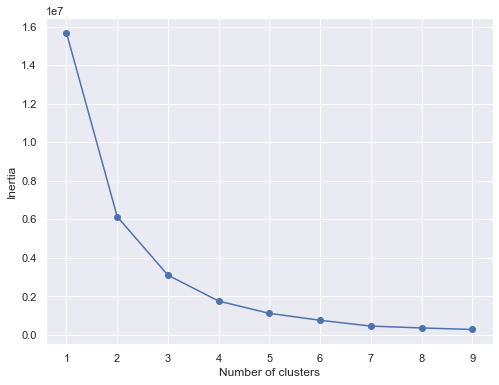

In [25]:
inertias = []
for k in np.arange(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)

# plotting the elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 10), inertias, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

In [26]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
df_scaled['cluster_kmeans'] = kmeans.fit_predict(df_scaled)

In [27]:
df_scaled

,NR,cluster_agglomerative,cluster_kmeans
48,-0.858787,1,1
53,-0.482497,1,1
123,-0.815032,1,1
148,-0.745025,1,1
149,-0.885039,1,1
...,...,...,...
5916,-0.394988,1,1
5954,0.900149,2,0
5996,-0.889415,1,1
6016,0.501982,2,0


In [28]:
users = list(df_scaled.index)
groups = df_scaled['cluster_agglomerative']

grouped_users = {i: [] for i in range(n_clusters)}

for user, group in zip(users, groups):
    grouped_users[group].append(user)

for gp, ctr in grouped_users.items():
    print(f'Cluster {gp}: {ctr}\n')

Cluster 0: [424, 549, 889, 1015, 1088, 1150, 1181, 1285, 1449, 1680, 1941, 1980, 2063, 2909, 3391, 3618, 3808, 3841, 4169, 4227, 4277, 4344, 4508, 4510, 5367, 5795, 5831]

Cluster 1: [48, 53, 123, 148, 149, 173, 202, 216, 245, 302, 308, 319, 329, 331, 411, 438, 509, 528, 533, 543, 660, 692, 699, 721, 731, 770, 839, 855, 877, 984, 1050, 1068, 1069, 1112, 1117, 1120, 1125, 1137, 1194, 1203, 1207, 1224, 1242, 1246, 1264, 1266, 1274, 1298, 1303, 1317, 1333, 1340, 1354, 1422, 1425, 1451, 1465, 1470, 1496, 1579, 1613, 1632, 1635, 1671, 1675, 1737, 1741, 1748, 1749, 1764, 1780, 1812, 1835, 1837, 1884, 1889, 1897, 1899, 1920, 1926, 1943, 1988, 2010, 2012, 2030, 2073, 2077, 2092, 2109, 2124, 2453, 2544, 2793, 2857, 2878, 2887, 2934, 2962, 2986, 3018, 3029, 3118, 3182, 3280, 3285, 3308, 3312, 3320, 3336, 3389, 3410, 3462, 3475, 3476, 3483, 3491, 3519, 3562, 3589, 3610, 3648, 3650, 3681, 3683, 3693, 3705, 3724, 3768, 3821, 3823, 3834, 3842, 3884, 3885, 3929, 3934, 3942, 3999, 4016, 4021, 4033, 40

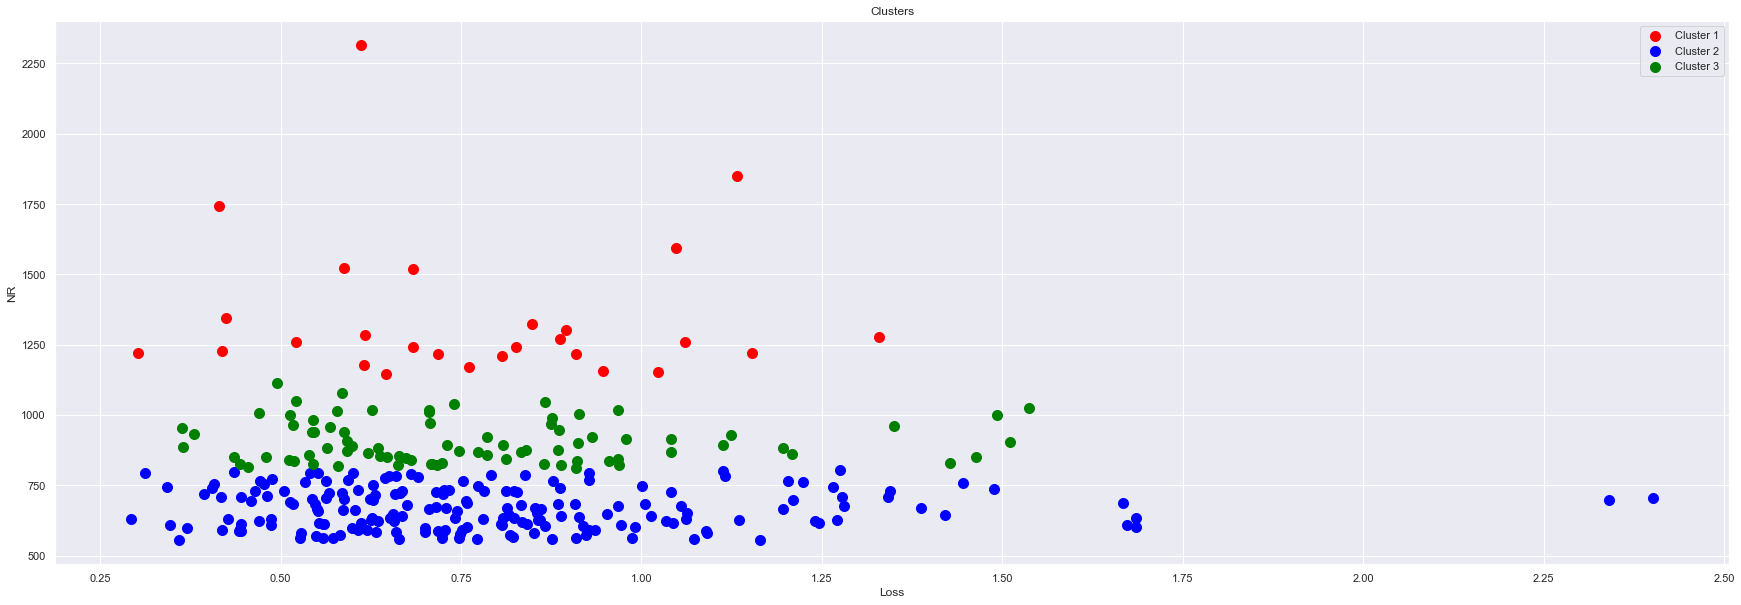

In [29]:
# visualising the clusters (Loss x NR)
df['Loss'] = losses
X2 = df[['Loss' , 'NR']].iloc[: , :].values

plt.figure( figsize=(30, 10)) # alterar tamanho
plt.xticks([-0.5,-0.25,0,0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]) # mudar escala do eixo X

plt.scatter(X2[groups == 0, 0], X2[groups == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X2[groups == 1, 0], X2[groups == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X2[groups == 2, 0], X2[groups == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.title('Clusters')
plt.xlabel('Loss')
plt.ylabel('NR')
plt.legend()
plt.show()

In [30]:
# clustering performance evaluation
from sklearn.metrics import davies_bouldin_score
print('davies_bouldin_score: ', davies_bouldin_score(df_scaled, kmeans.labels_))

from sklearn.metrics import silhouette_score
print('silhouette_score: ', silhouette_score(df_scaled, kmeans.labels_, metric='euclidean'))

davies_bouldin_score:  0.31680400250176993
silhouette_score:  0.7899079121417695


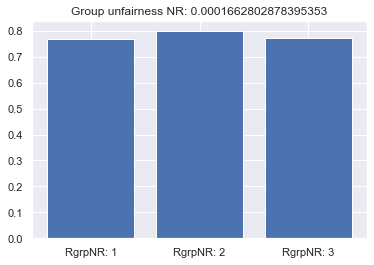

In [31]:
# G group: identifying the groups (NR: number of ratings of users)
# The configuration of groups was based in the hierarchical clustering (tree clustering - dendrogram)
# Clusters 1, 2 and 3
G = {1: [424, 549, 889, 1015, 1088, 1150, 1181, 1285, 1449, 1680, 1941, 1980, 2063, 2909, 3391, 3618, 3808, 3841, 4169, 4227, 4277, 4344, 4508, 4510, 5367, 5795, 5831], 2: [48, 53, 123, 148, 149, 173, 202, 216, 245, 302, 308, 319, 329, 331, 411, 438, 509, 528, 533, 543, 660, 692, 699, 721, 731, 770, 839, 855, 877, 984, 1050, 1068, 1069, 1112, 1117, 1120, 1125, 1137, 1194, 1203, 1207, 1224, 1242, 1246, 1264, 1266, 1274, 1298, 1303, 1317, 1333, 1340, 1354, 1422, 1425, 1451, 1465, 1470, 1496, 1579, 1613, 1632, 1635, 1671, 1675, 1737, 1741, 1748, 1749, 1764, 1780, 1812, 1835, 1837, 1884, 1889, 1897, 1899, 1920, 1926, 1943, 1988, 2010, 2012, 2030, 2073, 2077, 2092, 2109, 2124, 2453, 2544, 2793, 2857, 2878, 2887, 2934, 2962, 2986, 3018, 3029, 3118, 3182, 3280, 3285, 3308, 3312, 3320, 3336, 3389, 3410, 3462, 3475, 3476, 3483, 3491, 3519, 3562, 3589, 3610, 3648, 3650, 3681, 3683, 3693, 3705, 3724, 3768, 3821, 3823, 3834, 3842, 3884, 3885, 3929, 3934, 3942, 3999, 4016, 4021, 4033, 4048, 4054, 4083, 4089, 4140, 4186, 4305, 4345, 4354, 4387, 4411, 4482, 4578, 4579, 4682, 4728, 4732, 4802, 4867, 4957, 5011, 5015, 5054, 5074, 5107, 5111, 5220, 5306, 5312, 5387, 5433, 5493, 5501, 5504, 5511, 5530, 5536, 5550, 5605, 5675, 5682, 5747, 5759, 5763, 5878, 5880, 5888, 5916, 5996], 3: [195, 352, 482, 524, 531, 550, 678, 710, 752, 869, 881, 1010, 1019, 1051, 1383, 1447, 1448, 1605, 1647, 1676, 1698, 1733, 1880, 1912, 1958, 2015, 2106, 2116, 2181, 2304, 2507, 2529, 2665, 2777, 2820, 2907, 3032, 3067, 3163, 3224, 3272, 3292, 3311, 3401, 3471, 3507, 3526, 3539, 3626, 3675, 3778, 3792, 3824, 3829, 4041, 4064, 4085, 4238, 4312, 4386, 4425, 4447, 4448, 4543, 4647, 4725, 4808, 4979, 5026, 5046, 5100, 5256, 5333, 5394, 5614, 5627, 5636, 5643, 5788, 5812, 5954, 6016, 6036]}

glv = GroupLossVariance(X, omega, G, 1) #axis = 1 (0 rows e 1 columns)
losses_RgrpNR = glv.get_losses(X_est)
RgrpNR = glv.evaluate(X_est)

RgrpNR_groups = ['RgrpNR: 1', 'RgrpNR: 2', 'RgrpNR: 3']
plt.bar(RgrpNR_groups, losses_RgrpNR)
plt.title('Group unfairness NR: ' + str(RgrpNR))
plt.show()